## Calculate and save global integrals

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import esm2m.config_perturbations as cp
from dask.diagnostics import ProgressBar

In [4]:
variable='co2_flux_flux_ice_ocn'
override=False
# dd = cp.load_exps(variable=variable,override=override)
grid = cp.load_grid()
paths

/nbhome/gam/miniconda3/envs/wmt_bgc/lib/python3.9/site-packages/xarray/backends/plugins.py:107: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4']. Consider explicitly selecting one of the installed backends via the ``engine`` parameter to xarray.open_dataset(), or installing additional IO dependencies:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

#### STOP TRYING TO OVERCOMPLICATE THINGS
Just think carefully about what variables you need, do the calculations and be done. Don't worry about making everything perfect.

In [88]:
variables = ['jdic_100']
override=False
for variable in variables:
    dd = cp.load_exps(variable=variable,override=override)
    for e,ds in dd.items():
        # Get directory to save file in
        ppname = cp.get_variable_dict()[variable]
        outroot = '/work/gam/projects/bio-pump-timescales/esm2m/data/global_integrals/'
        if override:
            outroot = outroot+'override-po4/'
        else:
            outroot = outroot+'no-override/'
        outfile = ppname+e+'_'+variable+'.nc'
        outpath = outroot+outfile
        print(outpath)

        da = ds[variable]
        dadims = list(da.dims)
        daattrs = da.attrs.copy()
        if 'st_ocean' in dadims:
            factor = 1035.0 * grid['volume_t']
            daattrs['units'] = daattrs['units']+' * m3'
        else:
            factor = grid['area_t']
            daattrs['units'] = daattrs['units']+' * m2'
        # Remove time from list of dimensions before summing
        dadims.remove('time')
        dasum = ((da*factor).sum(dadims)
                 .assign_attrs(daattrs))
        dasum.name = variable
        with ProgressBar():
            dasum.to_dataset().to_netcdf(outpath)

/work/gam/projects/bio-pump-timescales/esm2m/data/global_integrals/no-override/ocean_bling_tracers_jdic_100.nc
[########################################] | 100% Completed |  0.5s
/work/gam/projects/bio-pump-timescales/esm2m/data/global_integrals/no-override/ocean_bling_tracers_gat_jdic_100.nc
[########################################] | 100% Completed |  0.4s
/work/gam/projects/bio-pump-timescales/esm2m/data/global_integrals/no-override/ocean_bling_tracers_zero_jdic_100.nc
[########################################] | 100% Completed |  0.4s
/work/gam/projects/bio-pump-timescales/esm2m/data/global_integrals/no-override/ocean_bling_tracers_double_jdic_100.nc
[########################################] | 100% Completed |  0.4s


In [90]:
dd['']['o2']

<xarray.DataArray 'o2' (time: 360, st_ocean: 50, yt_ocean: 200, xt_ocean: 360)>
dask.array<concatenate, shape=(360, 50, 200, 360), dtype=float32, chunksize=(120, 50, 200, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 4.588e+03 4.95e+03 5.316e+03
  * time      (time) object 0001-01-16 12:00:00 ... 0030-12-16 12:00:00
Attributes:
    long_name:      Oxygen
    units:          mol/kg
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

CPU times: user 22.9 s, sys: 31.7 s, total: 54.7 s
Wall time: 32.4 s


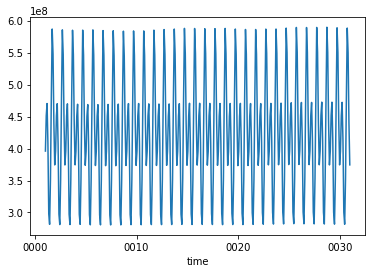

In [35]:
tmp = (dd['']['biomass_p']*grid['volume_t']).sum(['xt_ocean','yt_ocean','st_ocean'])
%time tmp.plot()

In [7]:
cp.dmget_exps(ppname='ocean_bling_tracers',wait=False,verbose=True)

dmget /archive/Richard.Slater/Siena/siena_201308_rds-c3-gat-slurm/MOM5_SIS_BLING_CORE2-gat/gfdl.ncrc3-intel16-prod-openmp/pp/ocean_bling_tracers/ts/monthly/10yr/ocean_bling_tracers.*.*.nc &
dmget /archive/Richard.Slater/Siena/siena_201308_rds-c3-gat-slurm/MOM5_SIS_BLING_CORE2-gat/gfdl.ncrc3-intel16-prod-openmp/pp/ocean_bling_gat_tracers/ts/monthly/10yr/ocean_bling_gat_tracers.*.*.nc &
dmget /archive/Richard.Slater/Siena/siena_201308_rds-c3-gat-slurm/MOM5_SIS_BLING_CORE2-gat/gfdl.ncrc3-intel16-prod-openmp/pp/ocean_bling_zero_tracers/ts/monthly/10yr/ocean_bling_zero_tracers.*.*.nc &
dmget /archive/Richard.Slater/Siena/siena_201308_rds-c3-gat-slurm/MOM5_SIS_BLING_CORE2-gat/gfdl.ncrc3-intel16-prod-openmp/pp/ocean_bling_double_tracers/ts/monthly/10yr/ocean_bling_double_tracers.*.*.nc &


In [17]:
grid

<xarray.Dataset>
Dimensions:    (xt: 360, xt_ocean: 360, xu_ocean: 360, yt: 200, yt_ocean: 200, yu_ocean: 200)
Coordinates:
  * xt         (xt) float64 -279.5 -278.6 -277.6 -276.6 ... 77.6 78.56 79.52
  * yt         (yt) float64 -81.5 -80.5 -79.5 -78.5 ... 78.0 78.35 78.62 78.78
    geolat_c   (yu_ocean, xu_ocean) float32 ...
    geolat_t   (yt_ocean, xt_ocean) float32 ...
    geolon_c   (yu_ocean, xu_ocean) float32 ...
    geolon_t   (yt_ocean, xt_ocean) float32 ...
  * xt_ocean   (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * xu_ocean   (xu_ocean) float64 -279.0 -278.0 -277.0 -276.0 ... 78.0 79.0 80.0
  * yt_ocean   (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... 87.5 88.5 89.5
  * yu_ocean   (yu_ocean) float64 -81.0 -80.0 -79.0 -78.0 ... 88.0 89.0 90.0
Data variables:
    CELL_AREA  (yt, xt) float32 ...
    COSROT     (yt, xt) float32 ...
    GEOLAT     (yt, xt) float32 ...
    GEOLON     (yt, xt) float32 ...
    SINROT     (yt, xt) float32 ...
    area_t     (yt_ocean, xt_ocean) float32 ...
    area_u     (yu_ocean, xu_ocean) float32 ...
    ht         (yt_ocean, xt_ocean) float32 ...
    hu         (yu_ocean, xu_ocean) float32 ...
    kmt        (yt_ocean, xt_ocean) float32 ...
    kmu        (yu_ocean, xu_ocean) float32 ...
Attributes:
    history:                    Tue Mar 17 16:13:07 2020: ncks --append --var...
    history_of_appended_files:  Tue Mar 17 16:13:07 2020: Appended file ./000...
    NCO:                        "4.5.4"